In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
from sklearn.cluster import KMeans, DBSCAN

In [3]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter=';')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Day_in_week"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,0,5
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5


# Data Preparation

In [4]:
# Clean - Drop Duplicates
df_clean = df.drop_duplicates(subset=["Date", "id"], keep="last").copy()
df_clean.shape

(467061, 22)

In [95]:
# Filtering out songs that appears less than 14 days
df_appear_count = df_clean.groupby('id').size().reset_index(name='count')
ids_to_be_used = df_appear_count[df_appear_count["count"] > 14]["id"]
df_clean = df_clean[df_clean["id"].isin(ids_to_be_used)]
df_clean.shape

(445363, 23)

### Day Since Appear

In [6]:
df_points = df_clean[["Points (Total)", "Date", "id"]].copy()
# df_points = df_points[:100000].copy()

# Calculate Day Since Appear
# df_points.sort_values(by=['id', 'Date'], inplace=True)
df_points['day_since_appear'] = df_points.groupby('id')['Date'].transform(lambda x: (x - x.min()).dt.days + 1)

In [7]:
# df_points['Points (Total)'] = pd.cut(df_points["Points (Total)"], bins=10, labels=range(1, 11)).astype(int)

### Fill in 0 for missing "Points (Total)"

In [8]:
day_since_appear = pd.Series(range(1,df_points['day_since_appear'].max()))
uuids = df_points["id"].unique()

all_combinations = pd.MultiIndex.from_product([uuids, day_since_appear], names=['id', 'day_since_appear'])
full_df = pd.DataFrame(index=all_combinations).reset_index()

merged_df = pd.merge(full_df, df_points, on=['id', 'day_since_appear'], how='left')
merged_df['Points (Total)'].fillna(0, inplace=True)
merged_df.head()

,id,day_since_appear,Points (Total),Date
0,3qQbCzHBycnDpGskqOWY0E,1,199.0,2023-04-28
1,3qQbCzHBycnDpGskqOWY0E,2,199.0,2023-04-29
2,3qQbCzHBycnDpGskqOWY0E,3,199.0,2023-04-30
3,3qQbCzHBycnDpGskqOWY0E,4,199.0,2023-05-01
4,3qQbCzHBycnDpGskqOWY0E,5,199.0,2023-05-02


<Axes: xlabel='day_since_appear', ylabel='Points (Total)'>

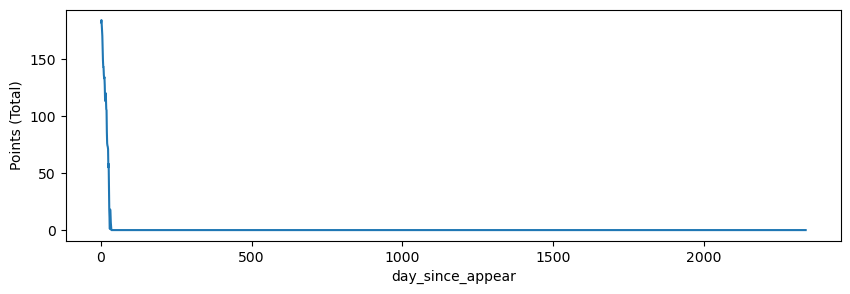

In [9]:
# Random song & Plot Popularity over time
plt.figure(figsize=(10,3))
sample = merged_df.sample(n=1).iloc[0]
sns.lineplot(merged_df[merged_df["id"] == sample["id"]], x="day_since_appear", y="Points (Total)")

In [10]:
# Pivot the DataFrame for clustering
pivot_df = merged_df.pivot(index='id', columns='day_since_appear', values='Points (Total)')
pivot_df.head()

day_since_appear,1,2,3,4,5,6,7,8,9,10,...,2330,2331,2332,2333,2334,2335,2336,2337,2338,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,151.0,133.0,134.0,153.0,158.0,161.0,160.0,154.0,152.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,6.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,193.0,191.0,189.0,194.0,192.0,192.0,190.0,182.0,184.0,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,11.0,24.0,31.0,44.0,60.0,59.0,57.0,70.0,81.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,96.0,156.0,146.0,146.0,127.0,112.0,99.0,71.0,62.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# pivot_df.to_csv("date_point_pop_only.csv")

In [12]:
# Calculate Differentitate
# df_diff = pivot_df.diff(axis=1)
# df_diff.drop(columns="2017-01-01", inplace=True)
# df_diff.head()

<Axes: xlabel='day_since_appear', ylabel='5wANPM4fQCJwkGd4rN57mH'>

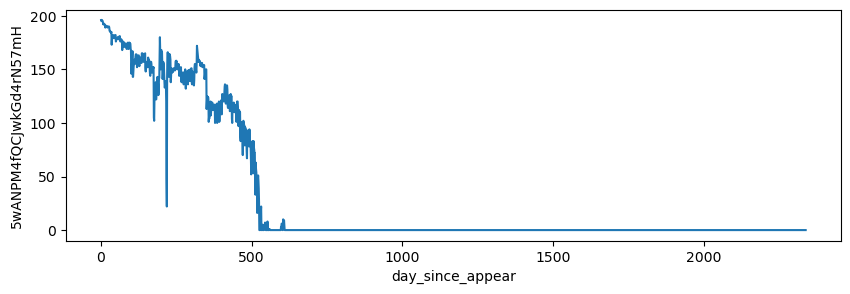

In [13]:
sample = pivot_df.sample(n=1)
sample_id = sample.index[0]

plt.figure(figsize=(10,3))
sns.lineplot(sample.iloc[0])

# plt.show()
# plt.figure(figsize=(10,3))
# sns.lineplot(df_diff.loc[sample_id])

# Song Popularity Over time

In [14]:
# all time hit, 6RUKPb4LETWmmr3iAEQktW, 5uCax9HTNlzGybIStD3vDh
# old release, but popular in 2022, 4xkOaSrkexMciUUogZKVTS, 4UKCKdYiLN6IMA5ZESUTL7, 1kKYjjfNYxE0YYgLa7vgVY
# popu. on and off, 2jyjhRf6DVbMPU5zxagN2h, 60a0Rd6pjrkxjPbaKzXjfq
# popu. on festival, 2TE4xW3ImvpltVU0cPcKUn, 15coTBAzEN1bOeipoNDZAR

id: 7zVCrzzEJU7u24sbJPXA5W | Total count: 28
Song: What Ifs (feat. Lauren Alai) | Artists: Kane Brown | Continent: Anglo-America


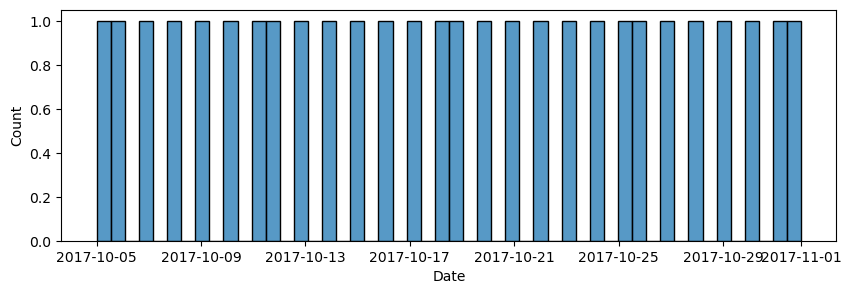

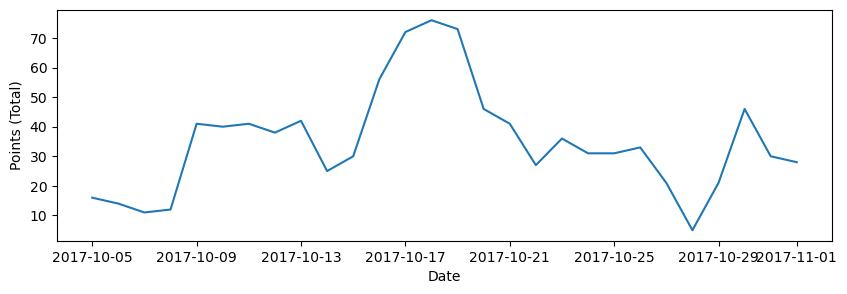

<Axes: xlabel='day_since_appear', ylabel='7zVCrzzEJU7u24sbJPXA5W'>

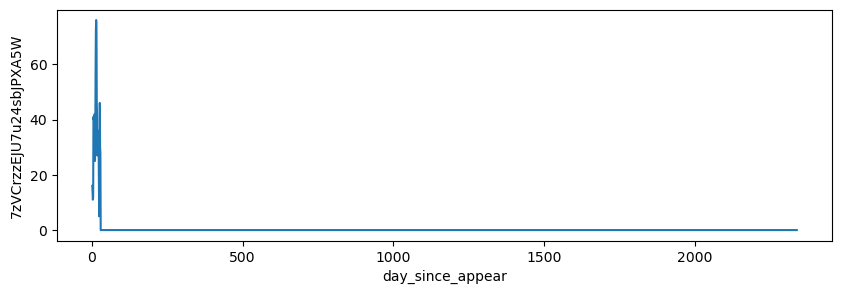

In [42]:
# sample = df_clean.sample(n=1).iloc[0]
sample = df_clean[df_clean["id"] == "7zVCrzzEJU7u24sbJPXA5W"].iloc[0]
df_focus = df_clean[df_clean["id"] == sample["id"]]

print(f'id: {sample["id"]} | Total count: {df_focus.shape[0]}')
print(f'Song: {sample["Title"]} | Artists: {sample["Artists"]} | Continent: {sample["Continent"]}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(pivot_df.loc[sample["id"]])


# Clustering

In [30]:
# # df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
# df_cluster_original = pivot_df.copy()

# dbscan = DBSCAN(eps=100)
# dbscan.fit(df_cluster_original)

# df_cluster = df_cluster_original.copy()
# df_cluster['cluster'] = dbscan.labels_
# labels = dbscan.labels_

# # pca = PCA(n_components=4)  # Reduce to 2 dimensions
# # X_2d = pca.fit_transform(df_cluster_original)

# # plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster["cluster"])

<Axes: xlabel='cluster', ylabel='Count'>

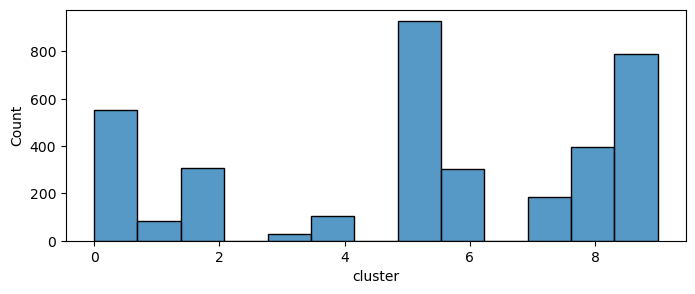

In [146]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = pivot_df.copy()

kmeans = KMeans(n_clusters=10, n_init="auto", max_iter=300)
kmeans.fit(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = kmeans.labels_
labels = kmeans.labels_

# pca = PCA(n_components=4)  # Reduce to 2 dimensions
# X_2d = pca.fit_transform(df_cluster_original)

# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

plt.figure(figsize=(8, 3))
sns.histplot(df_cluster["cluster"])

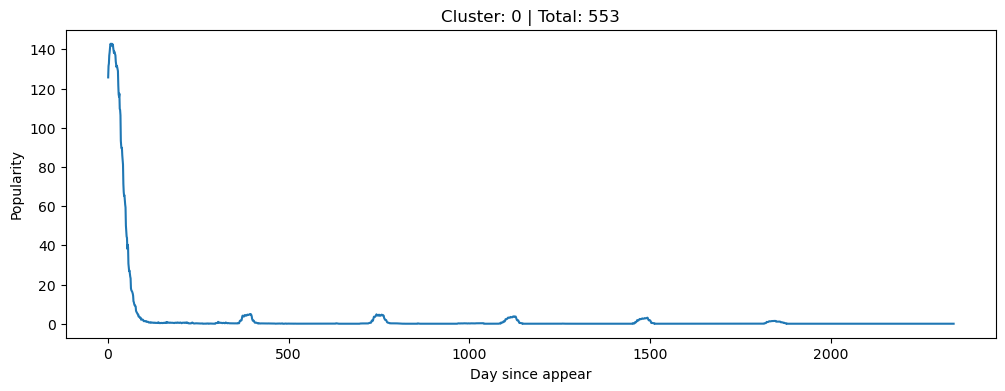

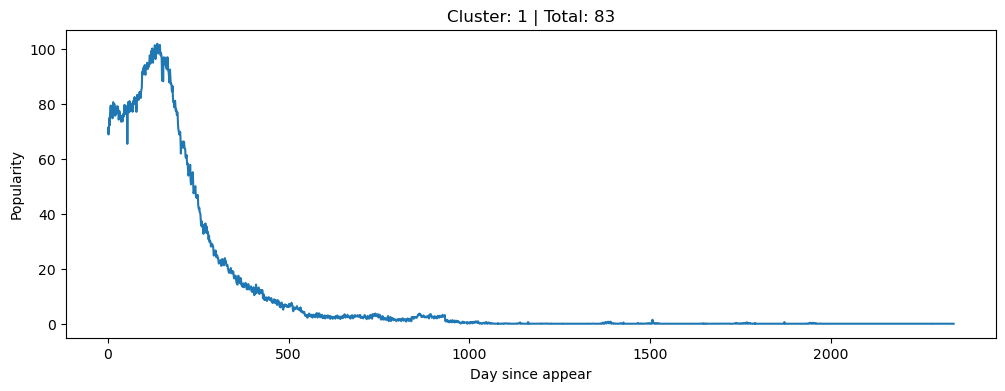

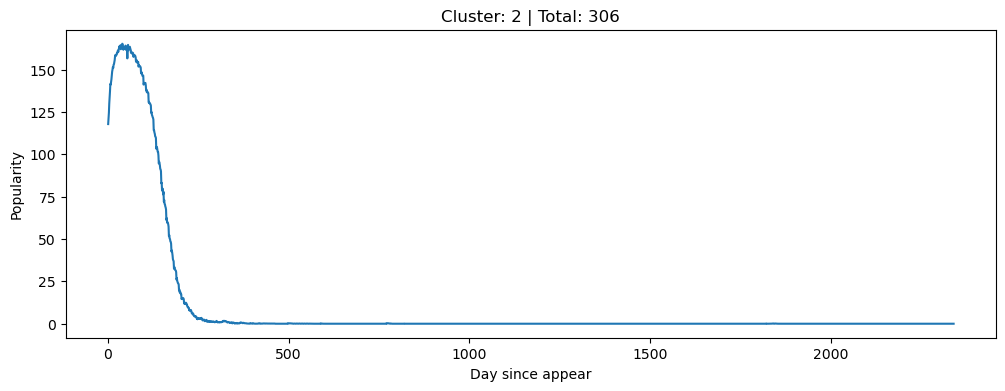

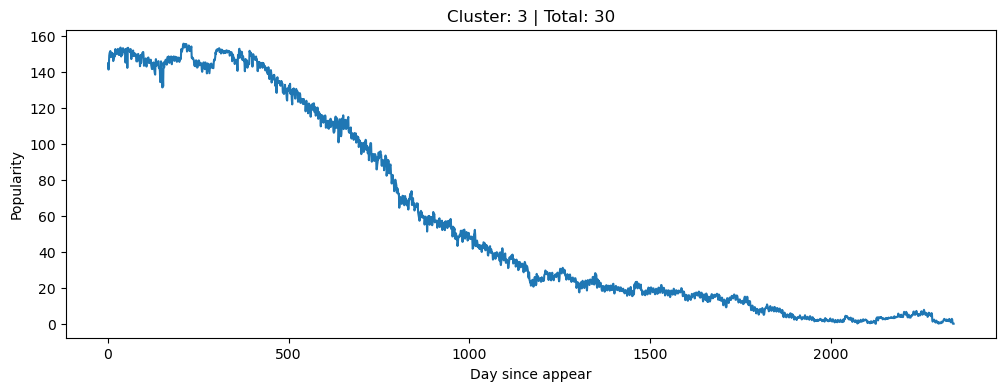

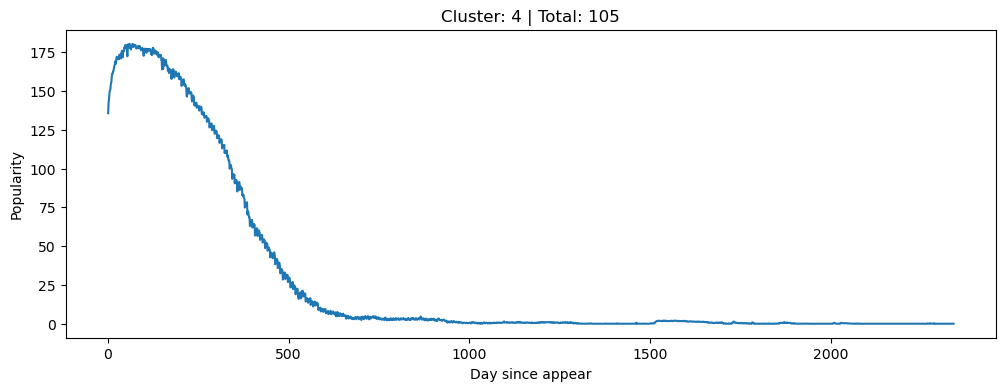

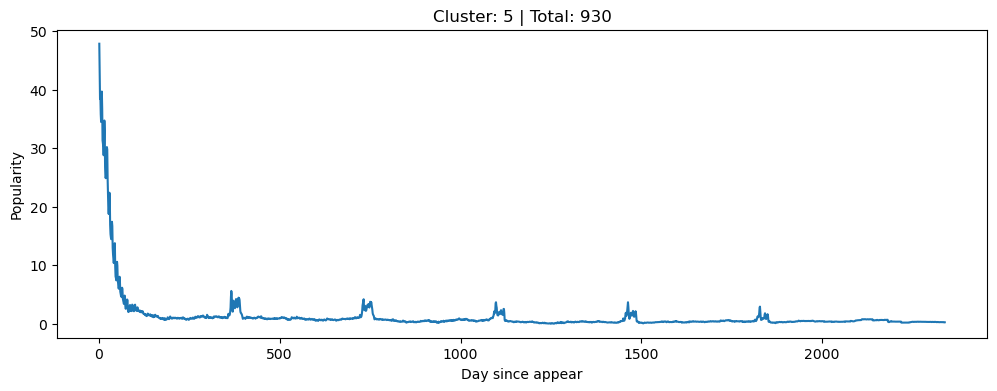

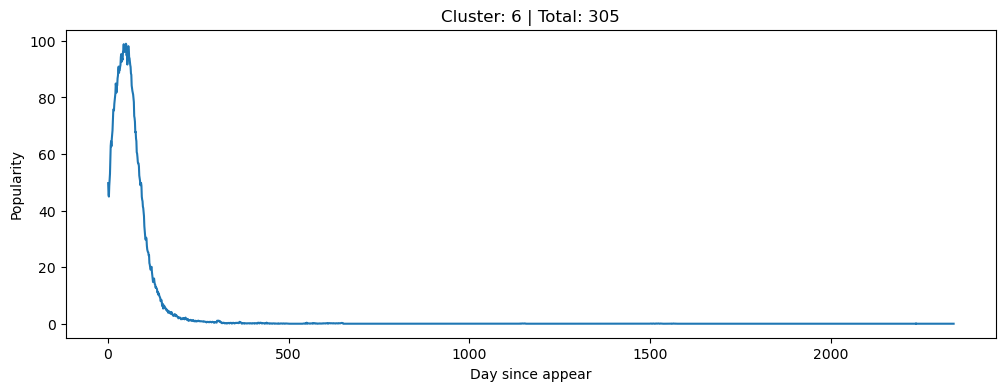

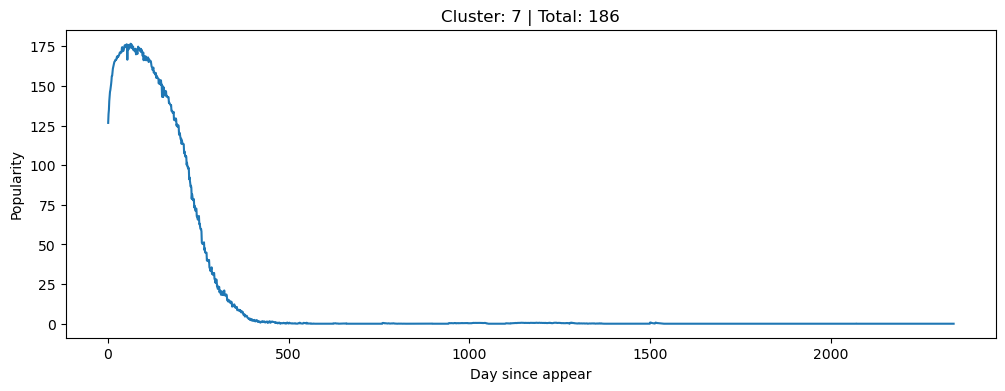

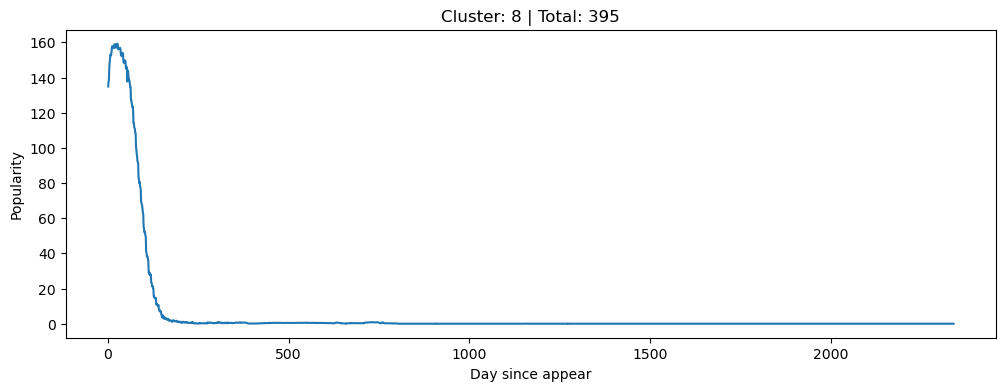

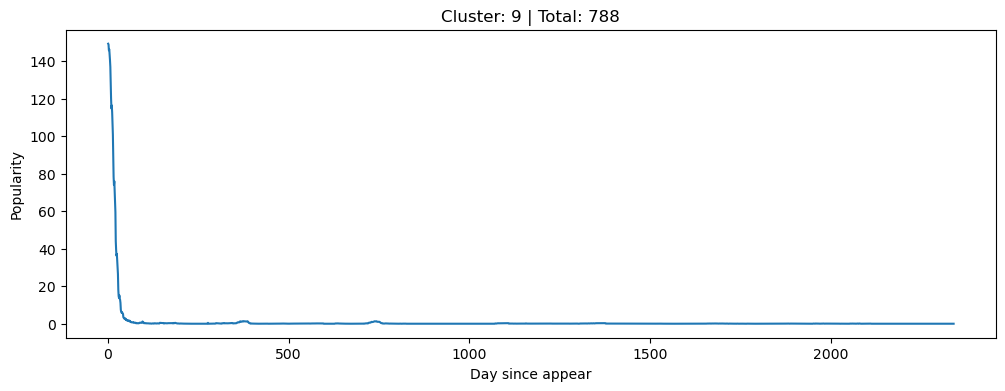

In [147]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
    sample = df_cluster[df_cluster["cluster"] == cluster]
    df_sample = sample.drop(columns="cluster").mean()

    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    plt.show()

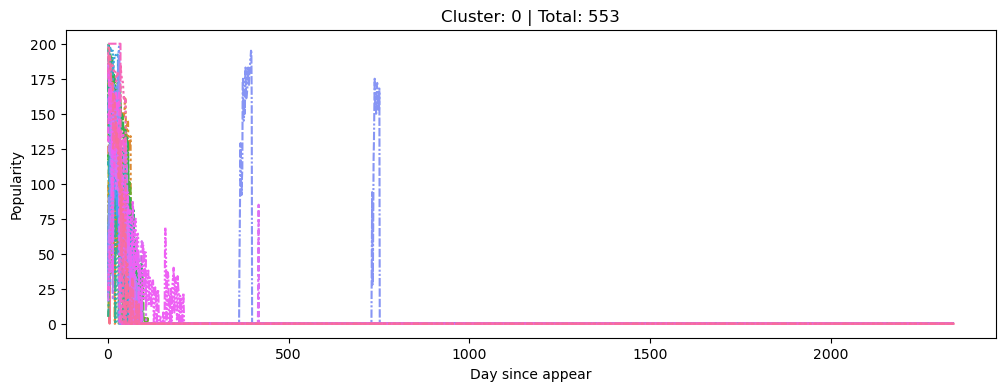

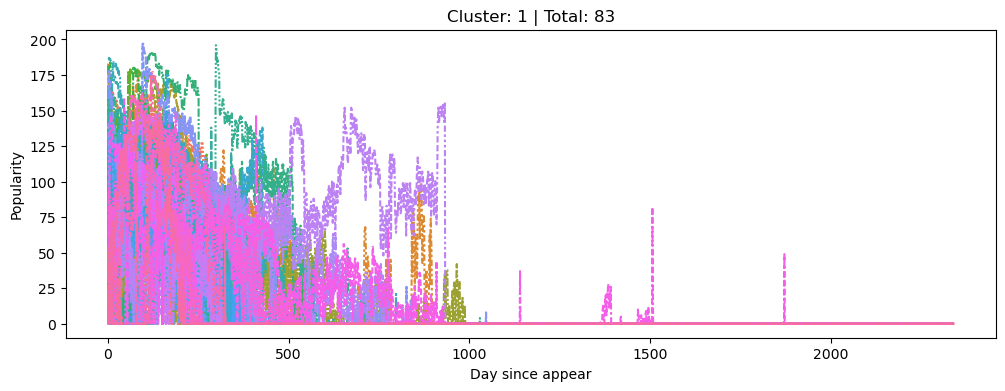

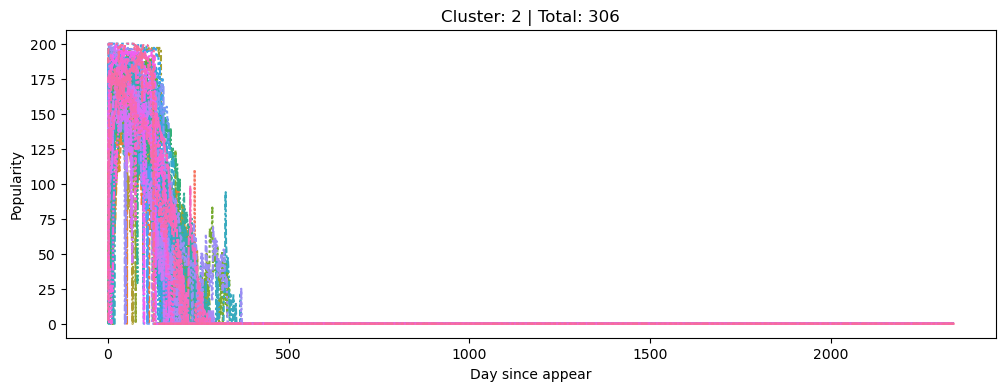

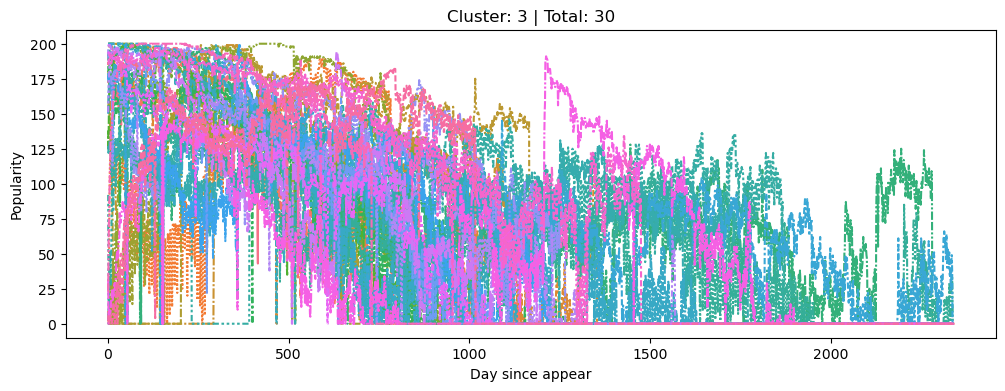

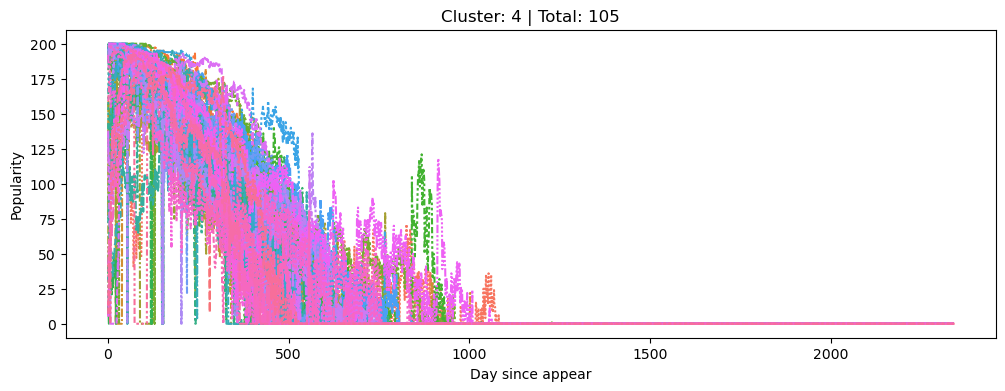

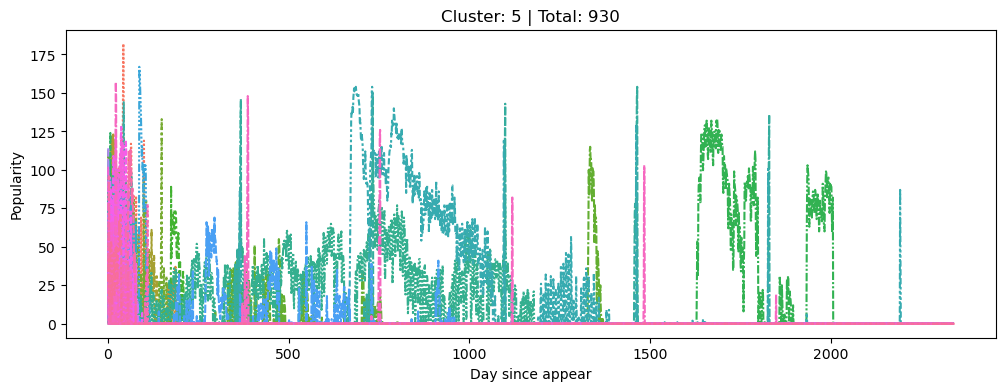

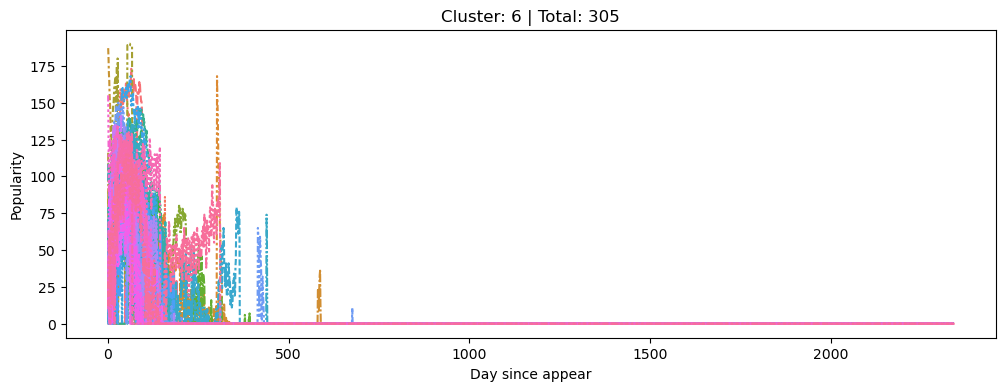

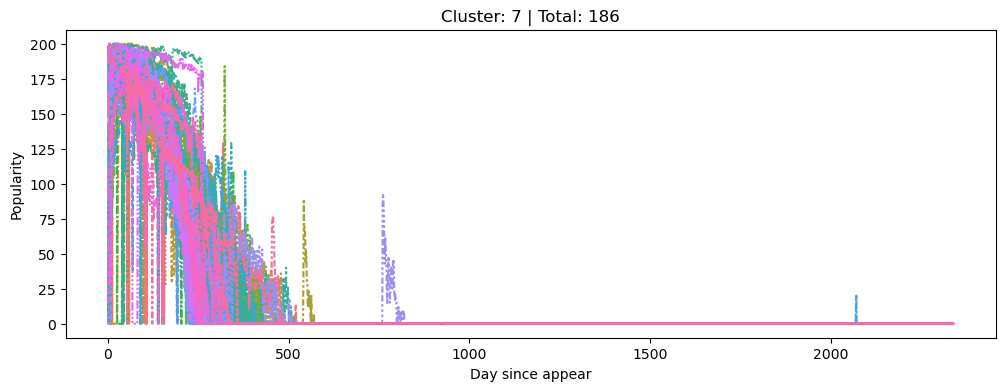

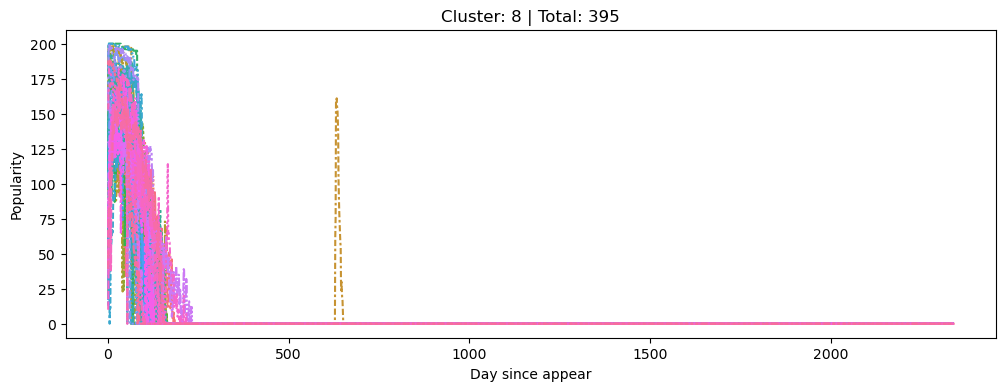

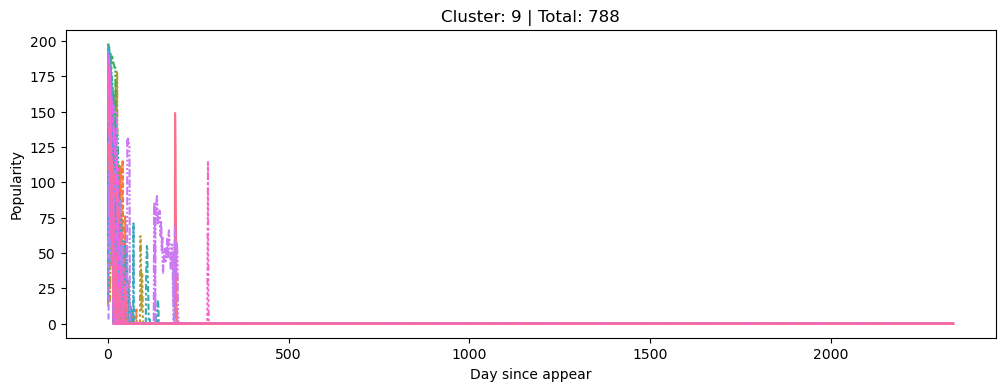

In [148]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
    sample = df_cluster[df_cluster["cluster"] == cluster].sample(min(cluster_size, 50))
    df_sample = sample.drop(columns="cluster")

    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    ax.get_legend().remove()
    plt.show()

In [43]:
# inspect each cluster
ids_to_be_used = df_cluster[df_cluster["cluster"] == 16].index
df_clean[df_clean["id"].isin(ids_to_be_used)].groupby("id").first()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),Song URL,Day_in_week,Month
id,,,,,,,,,,,,,,,,,,,,,
1kKYjjfNYxE0YYgLa7vgVY,192,Higher Love,"Kygo, Whitney Houston",2021-12-31,0.693,0.678,-7159.0,0.032,0.015,0.000,...,Artist 2,Whitney Houston,Nationality 2,United States,Anglo-America,9,4.5,https://open.spotify.com/track/1kKYjjfNYxE0YYg...,4,12
4UKCKdYiLN6IMA5ZESUTL7,200,the remedy for a broken heart (why am I so in ...,XXXTENTACION,2018-12-11,0.699,0.304,-11192.0,0.099,0.779,0.001,...,Artist 1,XXXTENTACION,Nationality 1,United States,Anglo-America,1,1.0,https://open.spotify.com/track/4UKCKdYiLN6IMA5...,1,12
4xkOaSrkexMciUUogZKVTS,198,'Till I Collapse,"Eminem, Nate Dogg",2023-02-01,0.548,0.847,-3237.0,0.186,0.062,0.000,...,Artist 2,Nate Dogg,Nationality 2,United States,Anglo-America,3,2.0,https://open.spotify.com/track/4xkOaSrkexMciUU...,2,2


# Clustering (Draft, TimeSeriesKMeans)

In [46]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 8.5 MB/s eta 0:00:00a 0:00:01


In [47]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = df_diff.copy()


km = TimeSeriesKMeans(n_clusters=10, metric="dtw")
labels = km.fit_predict(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = labels

plt.figure(figsize=(6, 3))
sns.histplot(df_cluster["cluster"])

# Visualise Correlation

In [150]:
df_result = df_clean.drop_duplicates(subset=["id"], keep="last")
df_result = df_result.join(df_cluster[["cluster"]], on='id')
df_result = df_result.join(df_appear_count.set_index('id'), on='id')

df_result = df_result[['id', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'cluster', 'count']].copy()

Text(0.5, 149.72222222222223, 'Cluster')

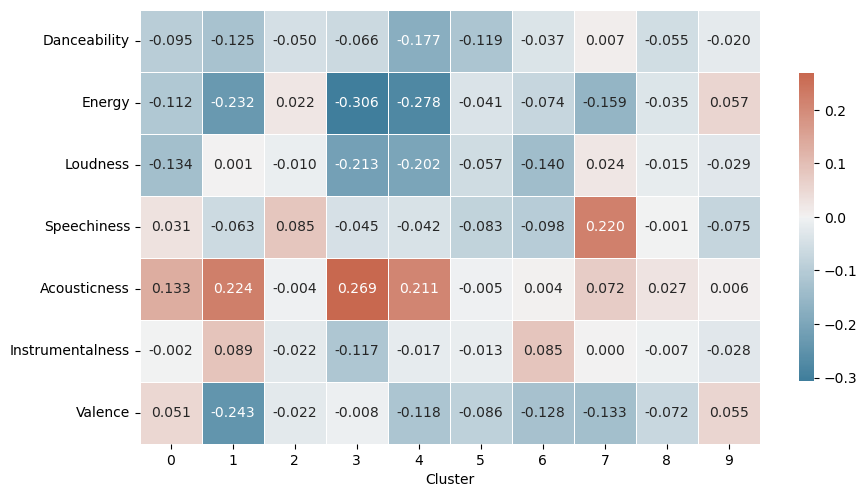

In [151]:
df_raw = df_result.drop(columns=['id']).copy()
df_corr_clus = pd.DataFrame()

for clus in sorted(df_raw["cluster"].unique()):
    df_corr = df_raw[df_raw["cluster"] == clus].drop(columns="cluster").corr()
    df_corr_clus[clus] = df_corr[["count"]].T.drop(columns="count").iloc[0]

# Draw the heatmap
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap((df_corr_clus), cmap=cmap, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')

plt.xlabel("Cluster")